## Coding 2
### Gaurav Shah (gns274)

In [429]:
#Import Libraries
import numpy as np
import pandas as pd
from scipy import integrate, optimize
import matplotlib.pyplot as plt 

In [430]:
#Define Variables (1)
a = 0.003
b = 0.002
s = 0.005
sigma_r = 0.02
c = 0.4
kappa_2 = 0.05
rho_infinity = 0.4
T = 10
notional = 50

In [431]:
#Define Variables (2)
v = np.sqrt(np.square(1/c) - 1 - 2*((rho_infinity/c) - 1))
sigma_1 = c * sigma_r
sigma_2 = v * sigma_1
rho_x = ((rho_infinity/c) - 1)/v
kappa = np.matrix([[0,0],
                  [0,kappa_2]])
sigma_x = np.matrix([[sigma_1,0],
                  [0,sigma_2]])

In [432]:
#Function for calculating y(t)
def matrix_calc(t_iter):
    B_t = np.matrix([[1,0],
                    [0,np.exp(-kappa_2*t_iter)]])
    q_t = np.matrix([[sigma_1,rho_x*sigma_1*sigma_2*(np.exp(kappa_2*t_iter))],
                    [rho_x*sigma_1*sigma_2*(np.exp(kappa_2*t_iter)),sigma_2*(np.exp(kappa_2*t_iter))]])
    temp_t = q_t.T * q_t
    integrate_temp_t = np.matrix([[np.square(sigma_1)*t_iter + (np.square(rho_x*sigma_1*sigma_2)*(np.exp(2*kappa_2*t_iter)-1))/(2*kappa_2), (np.square(sigma_1)*rho_x*sigma_2*(np.exp(kappa_2*t_iter)-1))/(kappa_2) + (np.square(sigma_2)*rho_x*sigma_1*(np.exp(2*kappa_2*t_iter)-1))/(2*kappa_2)],
                                   [(np.square(sigma_1)*rho_x*sigma_2*(np.exp(kappa_2*t_iter)-1))/(kappa_2) + (np.square(sigma_2)*rho_x*sigma_1*(np.exp(2*kappa_2*t_iter)-1))/(2*kappa_2), (np.square(rho_x*sigma_1*sigma_2)*(np.exp(2*kappa_2*t_iter)-1))/(2*kappa_2) + (np.square(sigma_2)*(np.exp(2*kappa_2*t_iter)-1))/(2*kappa_2)]])
    y_t = B_t * integrate_temp_t * B_t
    return y_t

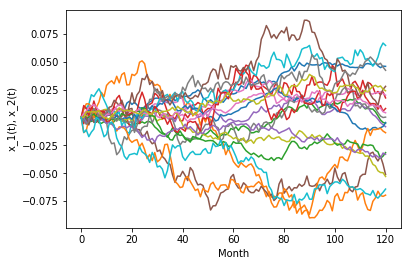

In [433]:
#Plots of paths of x(t)
delta_t = 1/12
u = np.matrix([[1],
              [1]])
for j in range(10):
    x_previous = np.matrix([[0],
                           [0]])
    x_1 = [0]
    x_2 = [0]
    z_array = np.random.normal(0,1,2*(int(T/delta_t))+1)
    for i in range(1,int(T/delta_t)+1):
        t = i*delta_t
        z_1 = z_array[i-1]
        z_2 = z_array[i+int(T/delta_t)]
        z_3 = rho_x * z_1 + ((1 - (rho_x**2))**0.5) * z_2
        z_t = np.matrix([[z_1],
                    [z_3]])
        dx_t = (matrix_calc(t-delta_t)*u - kappa*x_previous)*delta_t + sigma_x.T*z_t*(delta_t**0.5) 
        x_previous = x_previous + dx_t
        x_1.append(x_previous[0,0])
        x_2.append(x_previous[1,0])
    plt.plot(x_1)
    plt.plot(x_2)
plt.xlabel('Month')
plt.ylabel('x_1(t), x_2(t)')
plt.show()

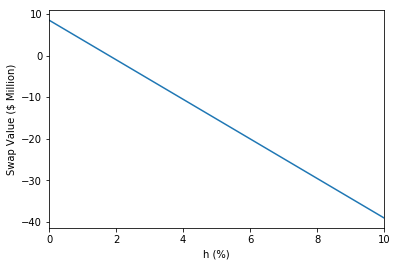

In [434]:
#Plots of V(0,x(0)) for different values of h (fixed coupon)
delta_t = 0.5
V_0_x_0_list = []
for h in np.arange(0,10.0001,1):
    V_0_x_0 = 0
    for T_iter in np.arange(0.5,10.0001,0.5):
        V_0_x_0 = V_0_x_0 + notional*((np.exp(s*delta_t)*np.exp(-a*(T_iter-delta_t)-b*((T_iter-delta_t)**2)/2) - np.exp(-a*T_iter-b*(T_iter**2)/2)*(1+delta_t*((h/100)))))
    V_0_x_0_list.append(V_0_x_0)
h = np.arange(0,11)
plt.plot(h,V_0_x_0_list)
plt.xlim(0,10)
plt.xlabel('h (%)')
plt.ylabel('Swap Value ($ Million)')
plt.show()

In [435]:
#Function for finding hpar
delta_t = 0.5
def find_hpar(r):
    h = r[0]
    V_0_x_0 = 0
    for T_iter in np.arange(0.5,10.0001,0.5):
        t = i*delta_t
        V_0_x_0 = V_0_x_0 + notional*((np.exp(s*delta_t)*np.exp(-a*(T_iter-delta_t)-b*((T_iter-delta_t)**2)/2) - np.exp(-a*T_iter-b*(T_iter**2)/2)*(1+delta_t*((h/100)))))
    return V_0_x_0

In [436]:
#Solve for hpar value 
hpar_value = optimize.fsolve(find_hpar,[0])[0]
hpar_value = hpar_value / 100
print("hpar = ", round(hpar_value*100,4),"%")

hpar =  1.7865 %


In [437]:
#Function for calculating F(t,x(t),T)
def F(t_iter,x_t,T_iter,y_t,P_0_t):
    G_t_T = np.matrix([[T_iter-t_iter],
               [(1 - np.exp(-kappa_2*(T_iter-t_iter)))/kappa_2]])
    P_0_T = np.exp(-a*T_iter-(b*(T_iter**2)/2))
    P_t_T = (P_0_T/P_0_t) * np.exp(-G_t_T.T * x_t - (G_t_T.T * y_t * G_t_T)/2)
    return P_t_T

In [438]:
#Function for calculating the values of Payer and Receiver legs
def payer_receiver(t_iter,x_t,y_t,P_0_t,delta_T):
    sum_payer = 0
    sum_receiver = 0
    for T_iter in np.arange((int(t_iter/0.5)+1)*0.5,10.0001,delta_T):
        if(T_iter==(int(t_iter/0.5)+1)*0.5):
            sum_receiver = sum_receiver + notional*np.exp(s*delta_T)*F(t_iter,x_t,T_iter-delta_T,y_t,P_0_t)
            temp = F(t_iter,x_t,T_iter,y_t,P_0_t)
            sum_payer = sum_payer + notional*temp*(1+(hpar_value*delta_T))
        else:
            sum_receiver = sum_receiver + notional*np.exp(s*delta_T)*temp
            temp = F(t_iter,x_t,T_iter,y_t,P_0_t)
            sum_payer = sum_payer + notional*temp*(1+(hpar_value*delta_T))
    return (sum_payer,sum_receiver)

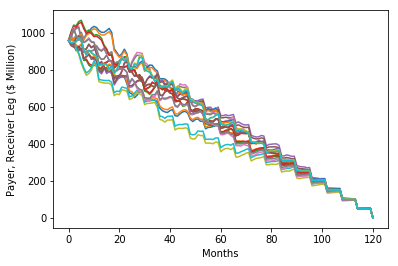

In [439]:
#Plots of paths of Payer and Receiver legs
delta_t = 1/12
delta_T = 0.5
u = np.matrix([[1],
              [1]])

for j in range(10):
    x_previous = np.matrix([[0],
                           [0]])
    payer_list = []
    receiver_list = []
    z_array = np.random.normal(0,1,2*(int(T/delta_t))+1)
    for i in range(0,int(T/delta_t)+1):
        t_iter = i*delta_t
        z_1 = z_array[i]
        z_2 = z_array[i+int(T/delta_t)]
        z_3 = rho_x * z_1 + ((1 - (rho_x**2))**0.5) * z_2
        z_t = np.matrix([[z_1],
                    [z_3]])
        y_t = matrix_calc(t_iter)
        P_0_t = np.exp(-a*t_iter-(b*(t_iter**2)/2))
        payer, receiver = payer_receiver(t_iter,x_previous,y_t,P_0_t,delta_T)
        dx_t = (y_t*u - kappa*x_previous)*delta_t + sigma_x.T*z_t*(delta_t**0.5)
        x_previous = x_previous + dx_t
        payer_list.append(payer)
        receiver_list.append(receiver)
    plt.plot(payer_list)
    plt.plot(receiver_list)
plt.xlabel("Months")
plt.ylabel("Payer, Receiver Leg ($ Million)")
plt.show()

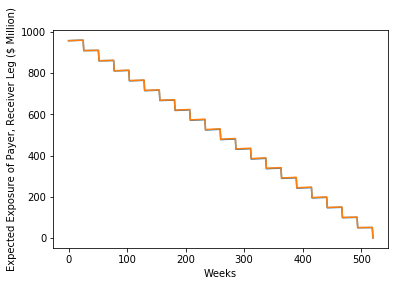

In [413]:
delta_t = 1/52
delta_T = 0.5
u = np.matrix([[1],
              [1]])
n_paths = 10000
total_payer_array = np.zeros(521)
total_receiver_array = np.zeros(521)
for j in range(n_paths):
    x_previous = np.matrix([[0],
                           [0]])
    payer_array = np.array([])
    receiver_array = np.array([])
    z_array = np.random.normal(0,1,2*(int(T/delta_t))+1)
    for i in range(0,int(T/delta_t)+1):
        t_iter = i*delta_t
        z_1 = z_array[i]
        z_2 = z_array[i+int(T/delta_t)]
        z_3 = rho_x * z_1 + ((1 - (rho_x**2))**0.5) * z_2
        z_t = np.matrix([[z_1],
                    [z_3]])
        y_t = matrix_calc(t_iter)
        P_0_t = np.exp(-a*t_iter-(b*(t_iter**2)/2))
        payer, receiver = payer_receiver(t_iter,x_previous,y_t,P_0_t,delta_T)
        dx_t = (y_t*u - kappa*x_previous)*delta_t + sigma_x.T*z_t*(delta_t**0.5)
        x_previous = x_previous + dx_t
        payer_array = np.append(payer_array,[max(payer,0)])
        receiver_array = np.append(receiver_array,[max(receiver,0)])
    total_payer_array = total_payer_array + payer_array
    total_receiver_array = total_receiver_array + receiver_array
total_payer_array = total_payer_array/n_paths
total_receiver_array = total_receiver_array/n_paths
plt.plot(total_payer_array)
plt.plot(total_receiver_array)
plt.xlabel("Weeks")
plt.ylabel("Expected Exposure of Payer, Receiver Leg ($ Million)")
plt.show()

### Note: The payer and receiver profile are plotted together on the same graph. The coincide with each other, thus what we see here is the payer and receiver profiles embedded on each other.

### Done